Notebook for automation of unit cell finding
Chris Nelson, ORNL
2024


Standard Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
from git import Repo,  InvalidGitRepositoryError

# General Settings

In [2]:
#parameters to generate dataset (below is a 2 atom hex TMD type image)
bounds = [0,128,0,64]                                                       #window
samplestep = .25                                                            #meshgrid sampling step
sampMesh = [bounds[0],bounds[1],samplestep,bounds[2],bounds[3],samplestep]  #meshgrid parameters for sampling
#Noise
countsPerPrimitive = 1000                                  #shot noise
baseNoiseRng = .5                                           #additive gaussian noise

Custom GIT Imports

In [3]:
gitlocal = ''
for i in sys.path:
    temp=i.split('\\')
    if temp[-1]=='site-packages':
        gitlocal=i

In [4]:
#Set local git repository location
gitremote = 'https://github.com/ctnelson/ctntools.git'
gitl = os.path.join(gitlocal,'ctntools')
print(gitl)

c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools


In [5]:
#check for local repo, pull if found
#clone git repo if not found locally
if os.path.exists(gitl):
    try:
        my_repo = Repo(gitl)
        o = my_repo.remotes.origin
        o.pull()
    except InvalidGitRepositoryError:
        Repo.clone_from(gitremote, gitl)
        my_repo = Repo(gitl)
else:
    Repo.clone_from(gitremote, gitl)
    my_repo = Repo(gitl)
print(my_repo)

<git.repo.base.Repo 'c:\\programs\\Anaconda3\\envs\\gpuenv\\lib\\site-packages\\ctntools\\.git'>


In [6]:
#Import custom functions from git repo
from ctntools.BaseSupportFunctions.createDataset import createDataset
from ctntools.StructureAnalysis.ucFromSymm import ucFromSymm

# Dataset 1: Hex (detailed)

Create dataset

c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Text(0.5, 1.0, 'Dataset')

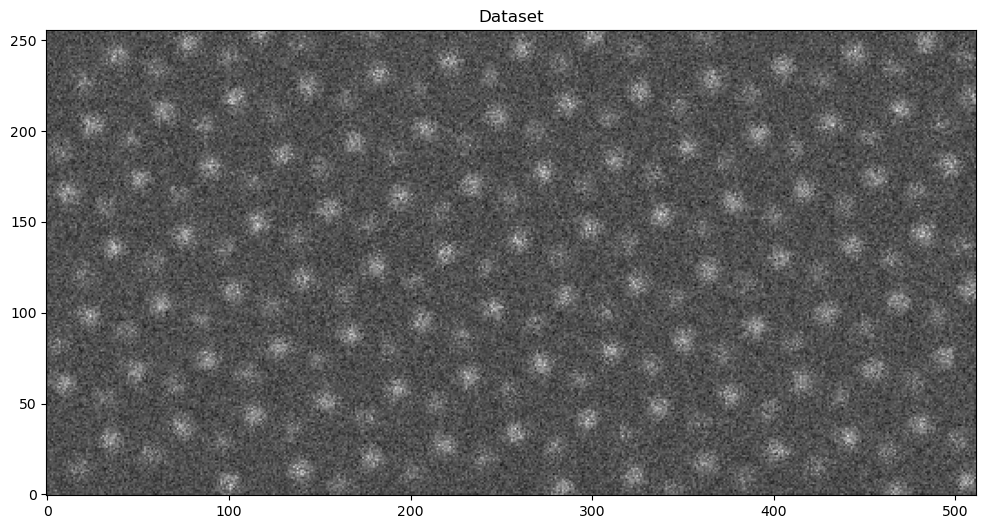

In [7]:
#basis & primitive
mag=10                                                      #basis vector magnitude
alpha = np.deg2rad(60)                                      #internal angle
atheta = np.deg2rad(10)                                     #a vector orientation
a=[np.cos(atheta)*mag, np.sin(atheta)*mag]                  #a basis vector
b=[np.cos(alpha+atheta)*mag, np.sin(alpha+atheta)*mag]      #b basis vector
primitive = [[1/3,1/3,1,1,1,0],[2/3,2/3,2,1,1,0]]           #[a, b, A, s1, s2, theta]

im, _, _, atoms,_,_, mgparams,_ = createDataset(bounds=bounds, method='Grid',sampMesh=sampMesh, primitive=primitive ,a=a, b=b, countsPerUnit=countsPerPrimitive, baseNoiseRng=baseNoiseRng)

#display
fig, ax = plt.subplots(1, 1, figsize=(12,12), dpi = 100)
ax.imshow(im,cmap='gray',origin='lower')
ax.set_title('Dataset')

Look for a unit cell as the center of 120deg rotation. Setting verbose = 2 to show execution details. Process is: 1)get spacing guess from fft, 2) perform bounded autocorrelation-ish function, 3)get ab basis vectors, 4)Get Symmetry map on scale of basis vectors, 5) unit cell positions are defined as maxima in weighted symmetry maps, 6) unit cells are classified by KMeans.

131072
Initial scale estimate by FFT: 14.40


c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (16) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (20) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


15625


Fitting swImDIff Peaks...: 100%|██████████| 26/26 [00:00<00:00, 145.00it/s]


Peak#25failure
Downsampled by [2x2]
0 Adding Rotation Symmetry 120.00 degrees
Checking Rotation (120.00 deg)...


c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Completed
32768


Creating Unit Cell Stack...: 100%|██████████| 55/55 [00:00<00:00, 1005.26it/s]
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Autoselected 1 classes


Creating Unit Cell Stack...: 100%|██████████| 55/55 [00:00<00:00, 1116.94it/s]
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools\Networks\findDefinedNbrs.py:53: RuntimeWarning: invalid value encountered in remainder
  if ((not np.isfinite(missingVal)) | (np.mod(missingVal,1)!=0)):


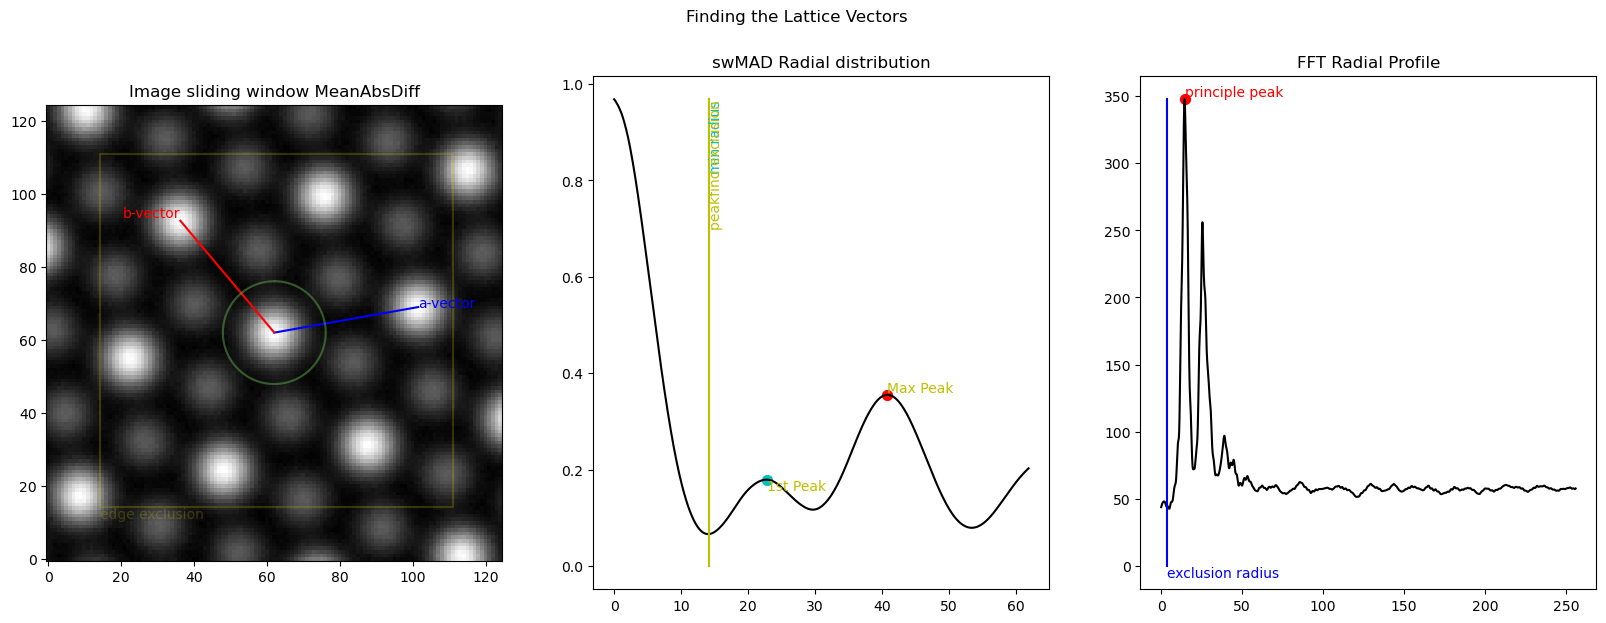

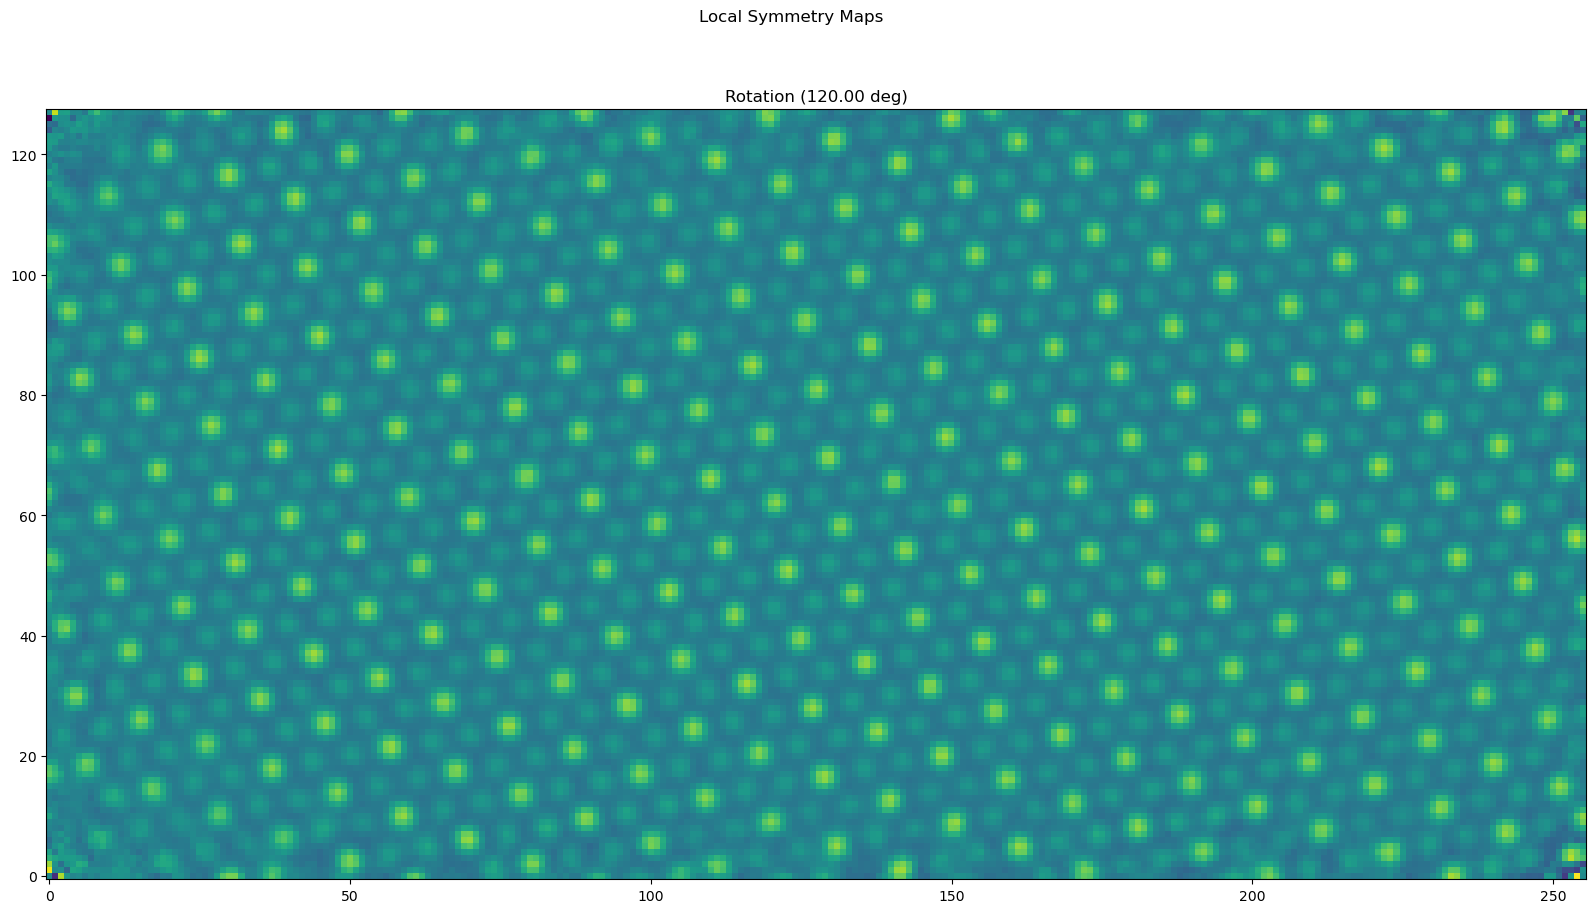

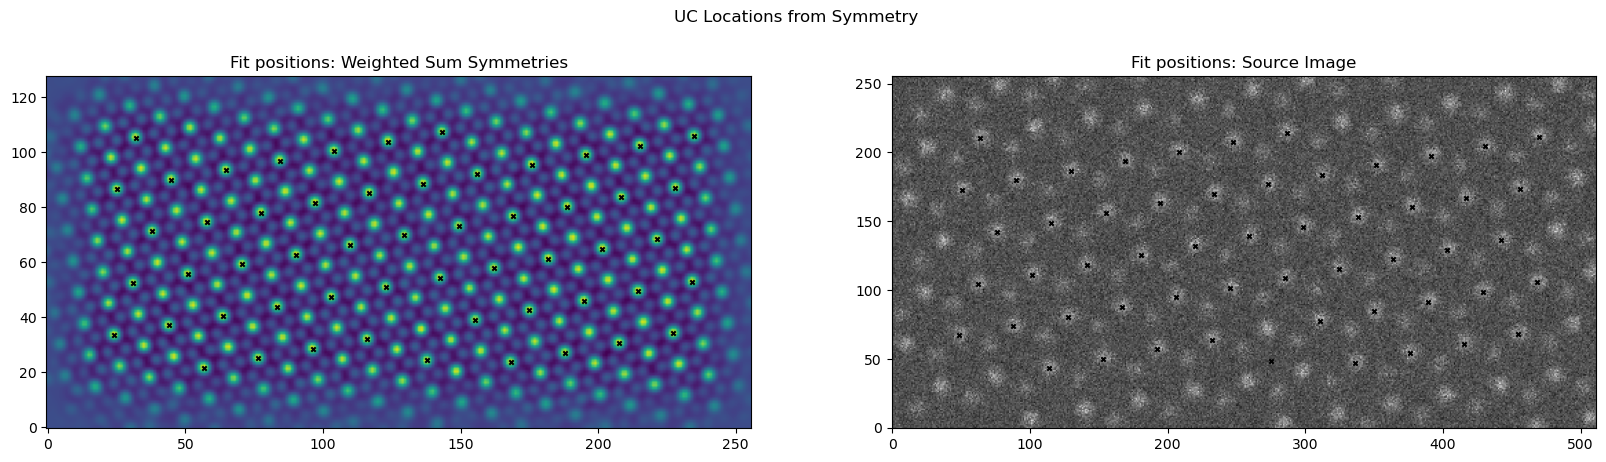

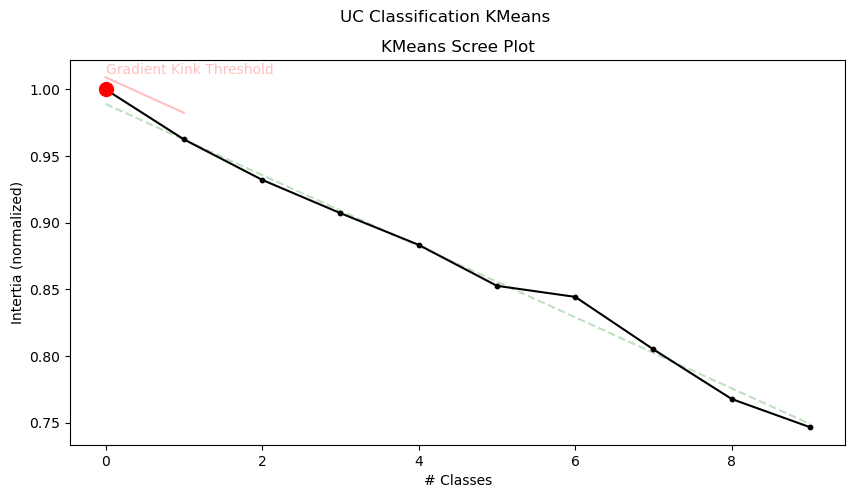

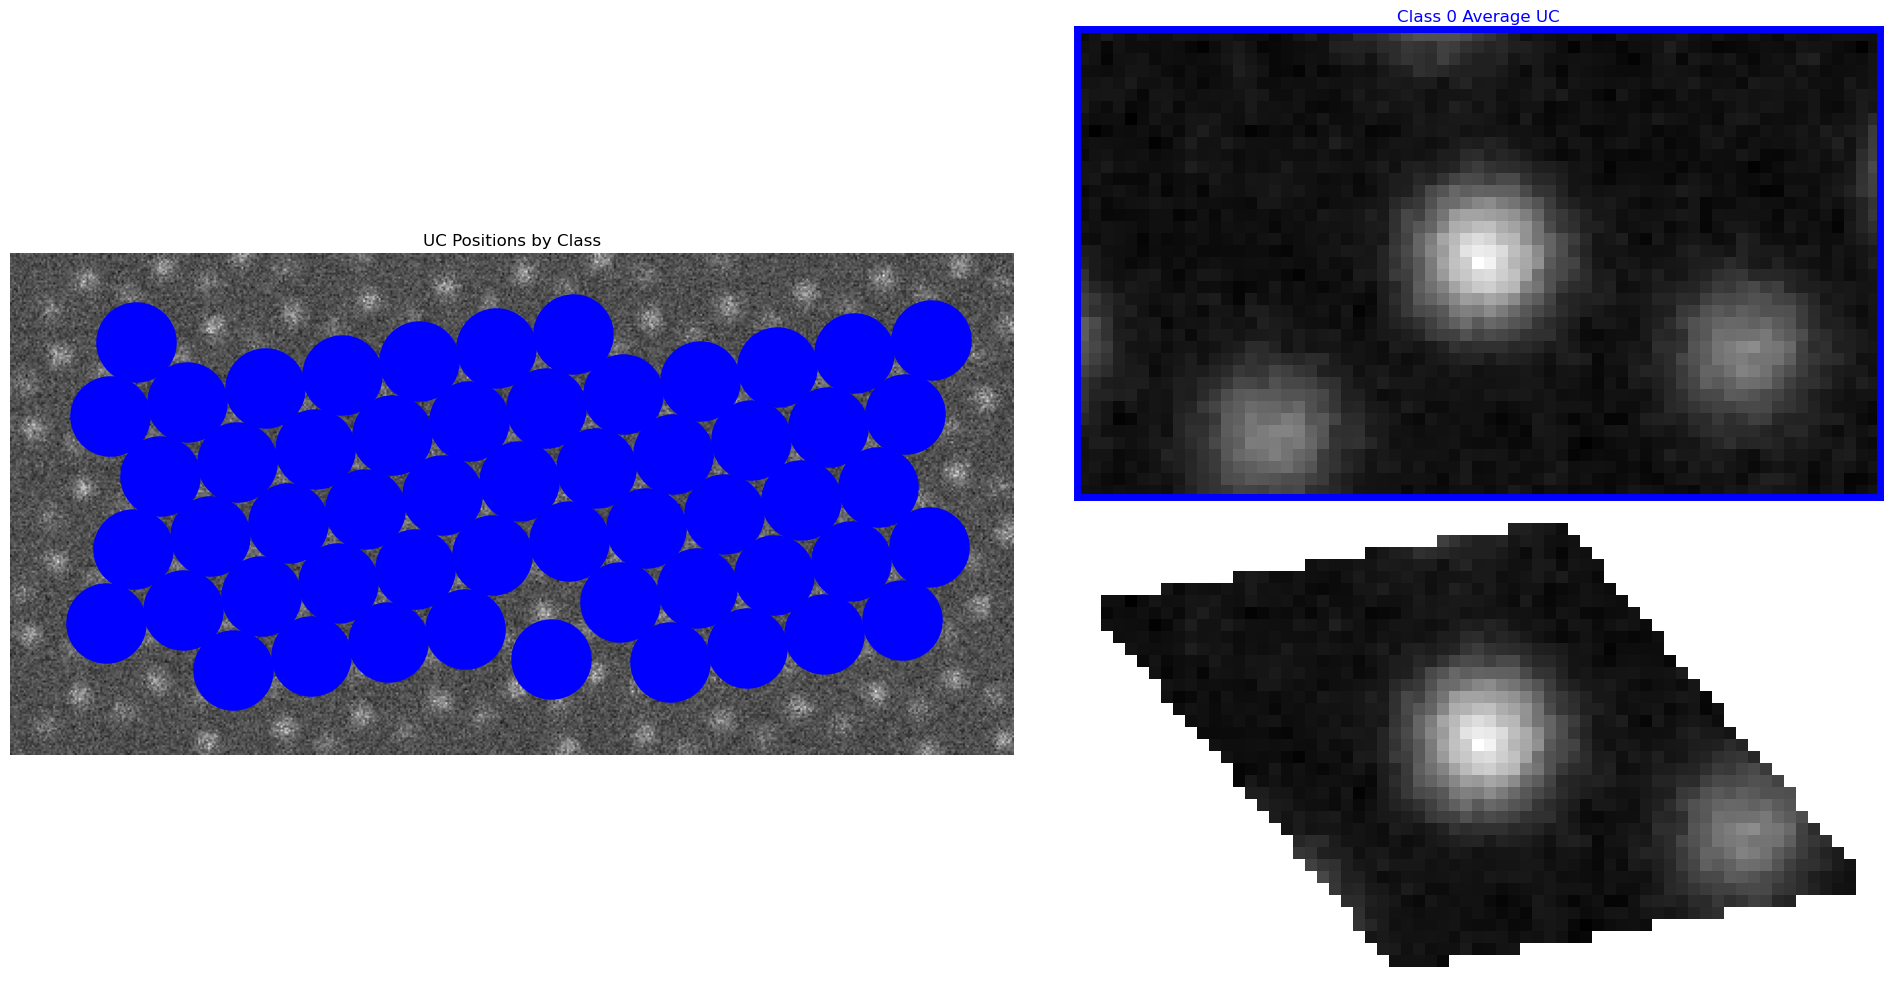

In [8]:
iM = {'r':[120]}                    #   :   symmetry to check
#Mwt = [.25,1,1]                     #   :   corresponding weights (for normalized, summed image)
alphaGuess=120
abUCoffset=[.5,.5]
verbose=2

ucAvg, UCmask, pks, UCSymmAvg, UCSymmMask, outDict = ucFromSymm(im, iM, abUCoffset=abUCoffset, alphaGuess=alphaGuess, verbose=verbose)

# Dataset 2: Cubic

Create Dataset

c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Text(0.5, 1.0, 'Dataset')

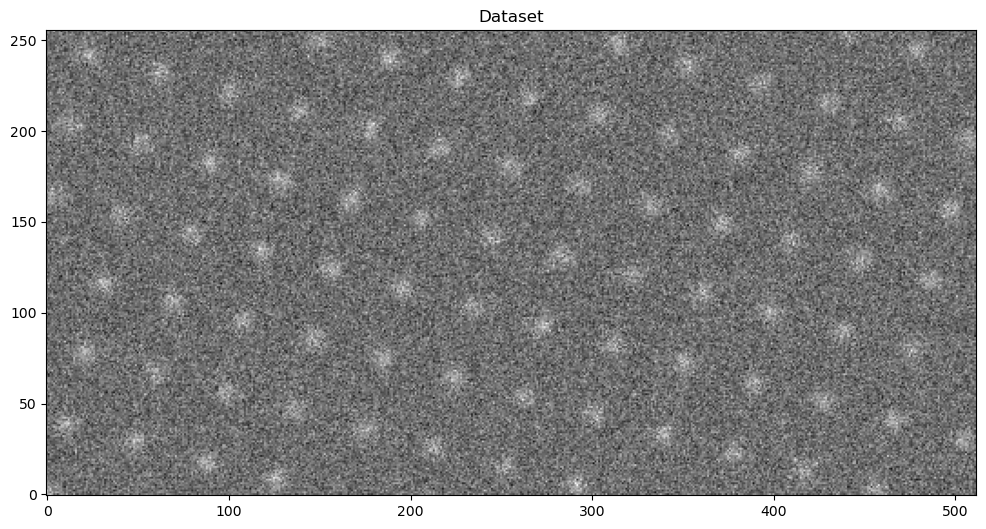

In [9]:
#basis & primitive
mag=10                                                      #basis vector magnitude
alpha = np.deg2rad(90)                                      #internal angle
atheta = np.deg2rad(-15)                                    #a vector orientation
a=[np.cos(atheta)*mag, np.sin(atheta)*mag]                  #a basis vector
b=[np.cos(alpha+atheta)*mag, np.sin(alpha+atheta)*mag]      #b basis vector
primitive = [[0,0,1,1,1,0]]           #[a, b, A, s1, s2, theta]

im, _, _, atoms,_,_, mgparams,_ = createDataset(bounds=bounds, method='Grid',sampMesh=sampMesh, primitive=primitive ,a=a, b=b, countsPerUnit=countsPerPrimitive, baseNoiseRng=baseNoiseRng)

#display
fig, ax = plt.subplots(1, 1, figsize=(12,12), dpi = 100)
ax.imshow(im,cmap='gray',origin='lower')
ax.set_title('Dataset')

131072


c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools\PeakFinding\peakfitting.py:38: RuntimeWarning: invalid value encountered in double_scalars
  xf = (2*coeff[5]*coeff[1]-coeff[2]*coeff[4])/(-4*coeff[3]*coeff[5]+coeff[4]**2)
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools\PeakFinding\peakfitting.py:40: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.arctan(coeff[4]/(coeff[3]-coeff[5]))/2
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (16) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerforman

11881


Fitting swImDIff Peaks...:   0%|          | 0/8 [00:00<?, ?it/s]c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools\PeakFinding\peakfitting.py:41: RuntimeWarning: invalid value encountered in double_scalars
  elipt = ((coeff[3]*(np.sin(theta)**2)-coeff[4]*np.sin(theta)*np.cos(theta) + coeff[5]*(np.cos(theta)**2))/(coeff[3]*(np.cos(theta)**2)+coeff[4]*(np.cos(theta)*np.sin(theta))+coeff[5]*(np.sin(theta)**2)))**.5
Fitting swImDIff Peaks...: 100%|██████████| 8/8 [00:00<00:00, 495.23it/s]


Downsampled by [2x2]
0 Adding Rotation Symmetry 90.00 degrees
Checking Rotation (90.00 deg)...
Completed
32768


Creating Unit Cell Stack...: 100%|██████████| 49/49 [00:00<00:00, 1274.56it/s]
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Autoselected 1 classes


Creating Unit Cell Stack...: 100%|██████████| 49/49 [00:00<00:00, 1308.10it/s]
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools\Networks\findDefinedNbrs.py:53: RuntimeWarning: invalid value encountered in remainder
  if ((not np.isfinite(missingVal)) | (np.mod(missingVal,1)!=0)):


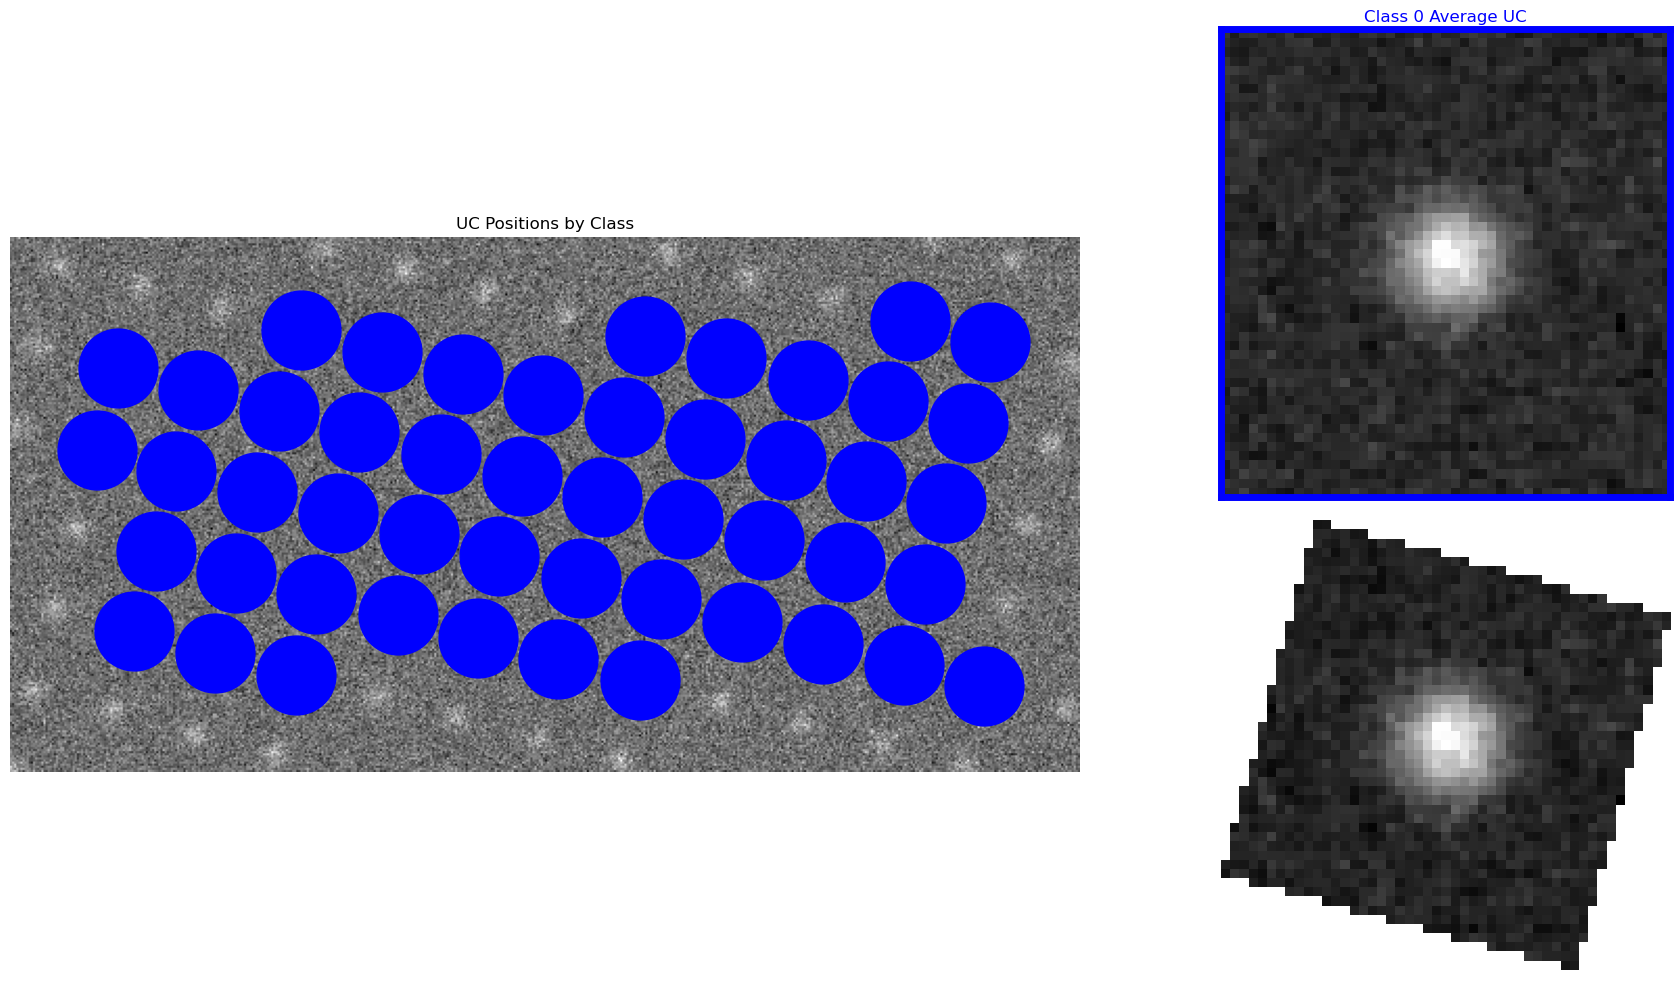

In [10]:
iM = {'r':[90]}                     #   :   symmetry to check
#Mwt = [.25,1,1]                     #   :   corresponding weights (for normalized, summed image)
alphaGuess=90
abUCoffset=[.5,.5]
verbose=1

ucAvg, UCmask, pks, UCSymmAvg, UCSymmMask, outDict = ucFromSymm(im, iM, abUCoffset=abUCoffset, alphaGuess=alphaGuess, verbose=verbose)

# Dataset 3: CsCl (deliberately find 2)

Create Dataset

c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Text(0.5, 1.0, 'Dataset')

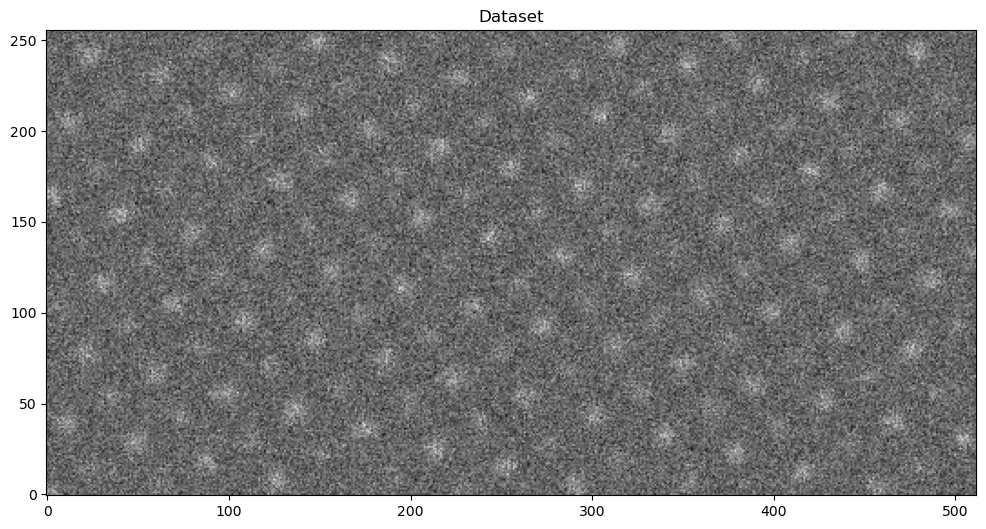

In [11]:
#basis & primitive
mag=10                                                      #basis vector magnitude
alpha = np.deg2rad(90)                                      #internal angle
atheta = np.deg2rad(-15)                                    #a vector orientation
a=[np.cos(atheta)*mag, np.sin(atheta)*mag]                  #a basis vector
b=[np.cos(alpha+atheta)*mag, np.sin(alpha+atheta)*mag]      #b basis vector
primitive = [[0,0,1,1,1,0],[0.5,0.5,.5,1,1,0]]           #[a, b, A, s1, s2, theta]

im, _, _, atoms,_,_, mgparams,_ = createDataset(bounds=bounds, method='Grid',sampMesh=sampMesh, primitive=primitive ,a=a, b=b, countsPerUnit=countsPerPrimitive, baseNoiseRng=baseNoiseRng)

#display
fig, ax = plt.subplots(1, 1, figsize=(12,12), dpi = 100)
ax.imshow(im,cmap='gray',origin='lower')
ax.set_title('Dataset')

The default

131072
Initial scale estimate by FFT: 17.50


c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (25) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (24) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


22201


Fitting swImDIff Peaks...:  21%|██▏       | 9/42 [00:00<00:00, 85.00it/s]c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools\PeakFinding\peakfitting.py:41: RuntimeWarning: invalid value encountered in double_scalars
  elipt = ((coeff[3]*(np.sin(theta)**2)-coeff[4]*np.sin(theta)*np.cos(theta) + coeff[5]*(np.cos(theta)**2))/(coeff[3]*(np.cos(theta)**2)+coeff[4]*(np.cos(theta)*np.sin(theta))+coeff[5]*(np.sin(theta)**2)))**.5
Fitting swImDIff Peaks...: 100%|██████████| 42/42 [00:00<00:00, 239.98it/s]


Downsampled by [2x2]
0 Adding Rotation Symmetry 90.00 degrees
Checking Rotation (90.00 deg)...
Completed
32768


Creating Unit Cell Stack...: 100%|██████████| 48/48 [00:00<00:00, 962.39it/s]
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Autoselected 1 classes


Creating Unit Cell Stack...: 100%|██████████| 48/48 [00:00<00:00, 1366.06it/s]
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools\Networks\findDefinedNbrs.py:53: RuntimeWarning: invalid value encountered in remainder
  if ((not np.isfinite(missingVal)) | (np.mod(missingVal,1)!=0)):


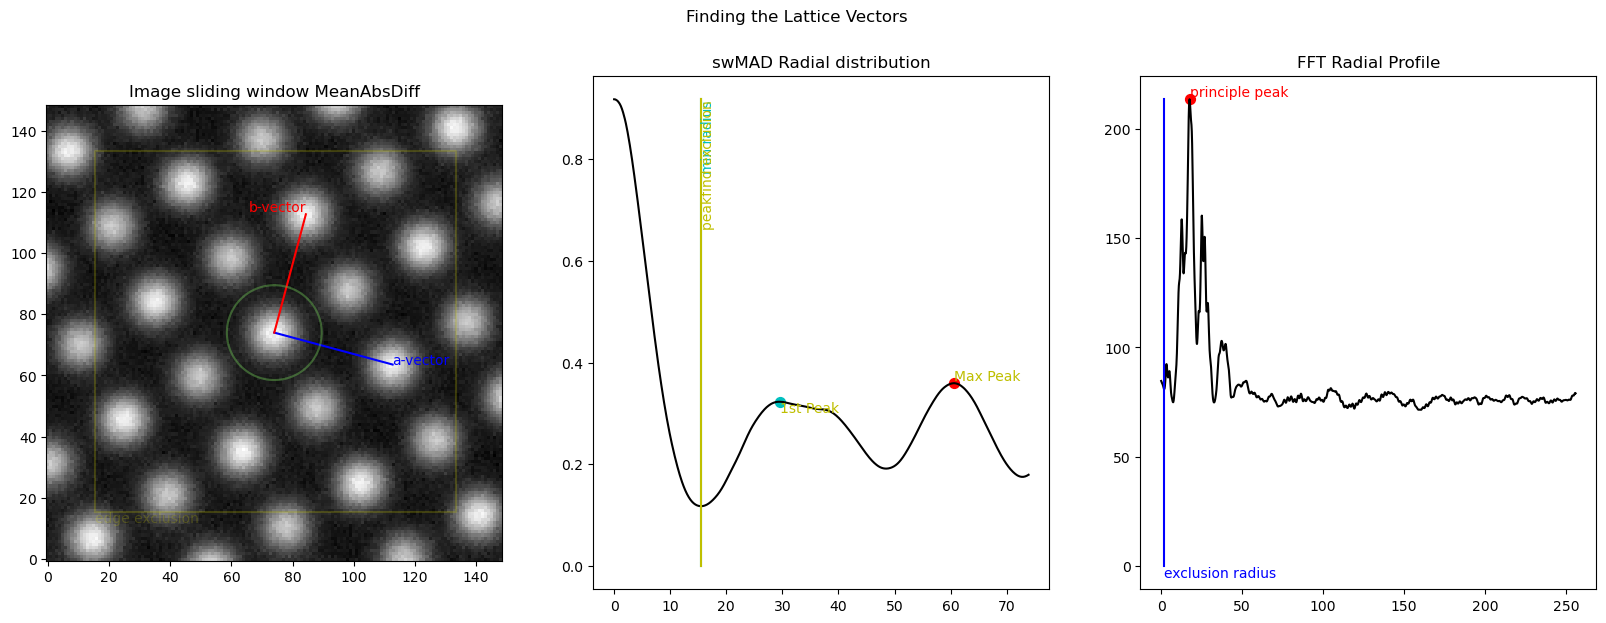

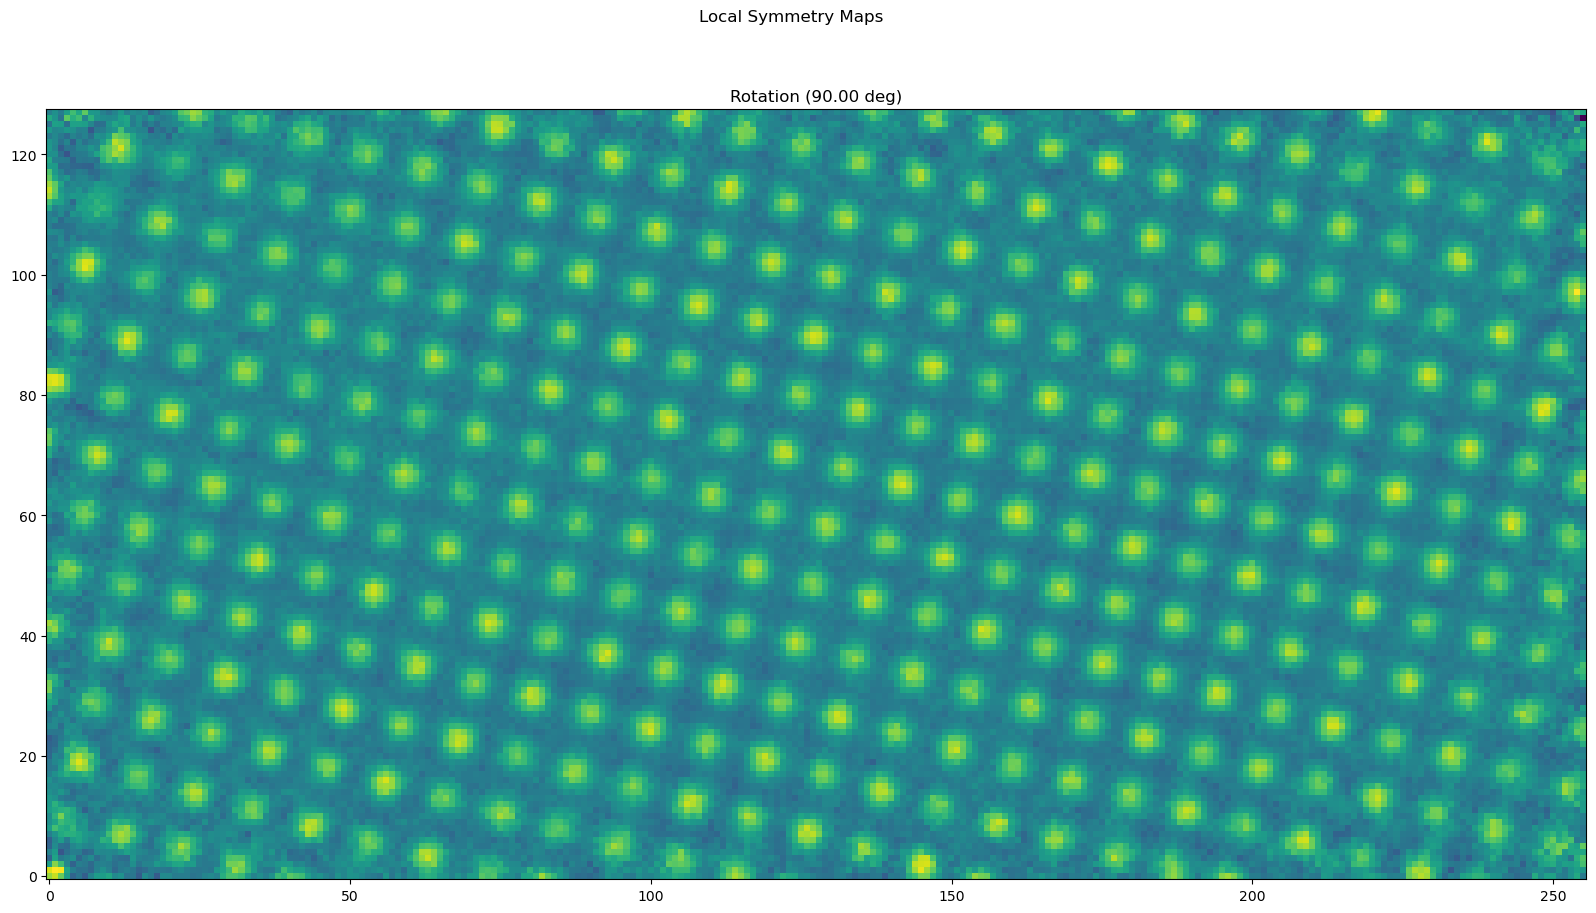

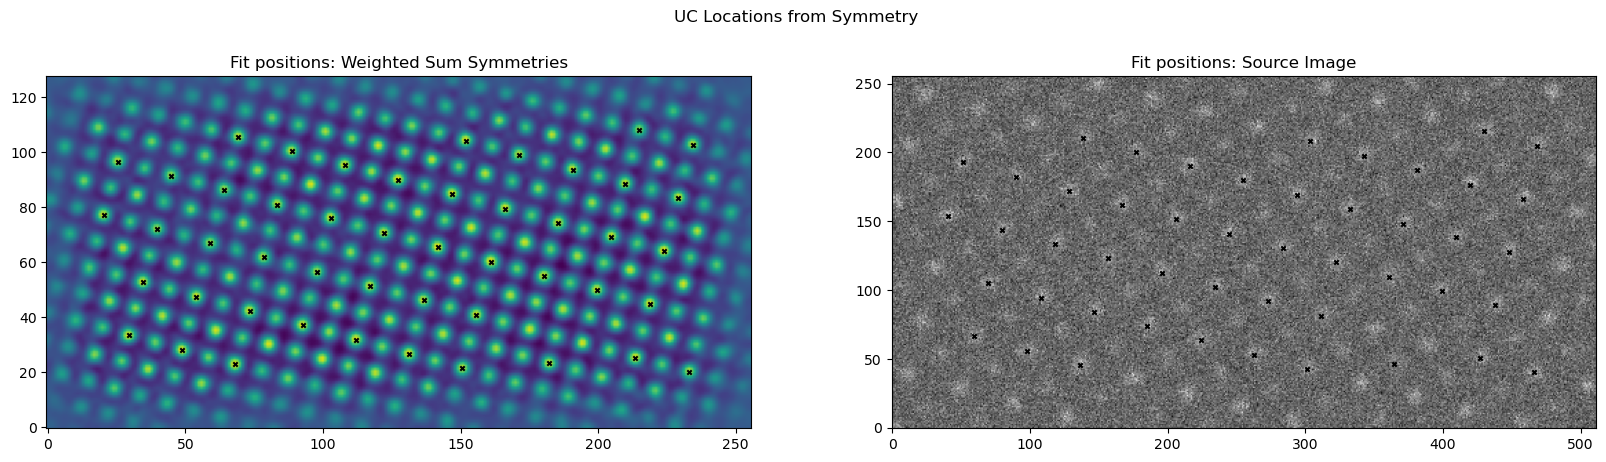

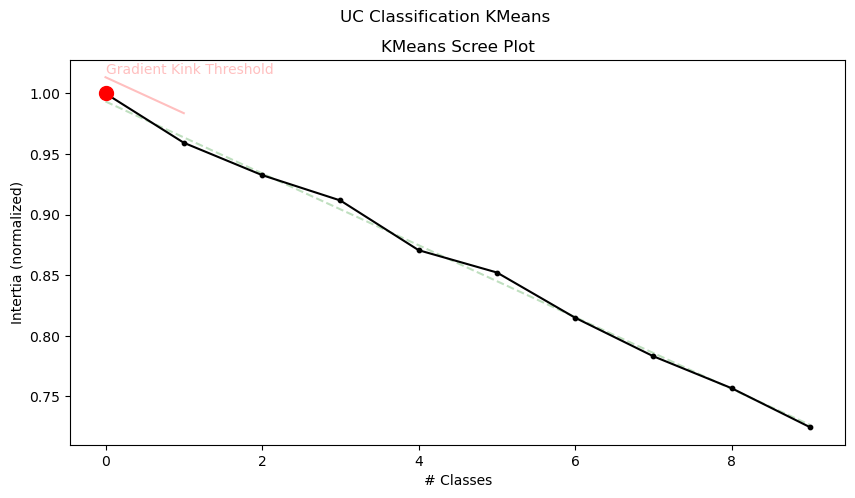

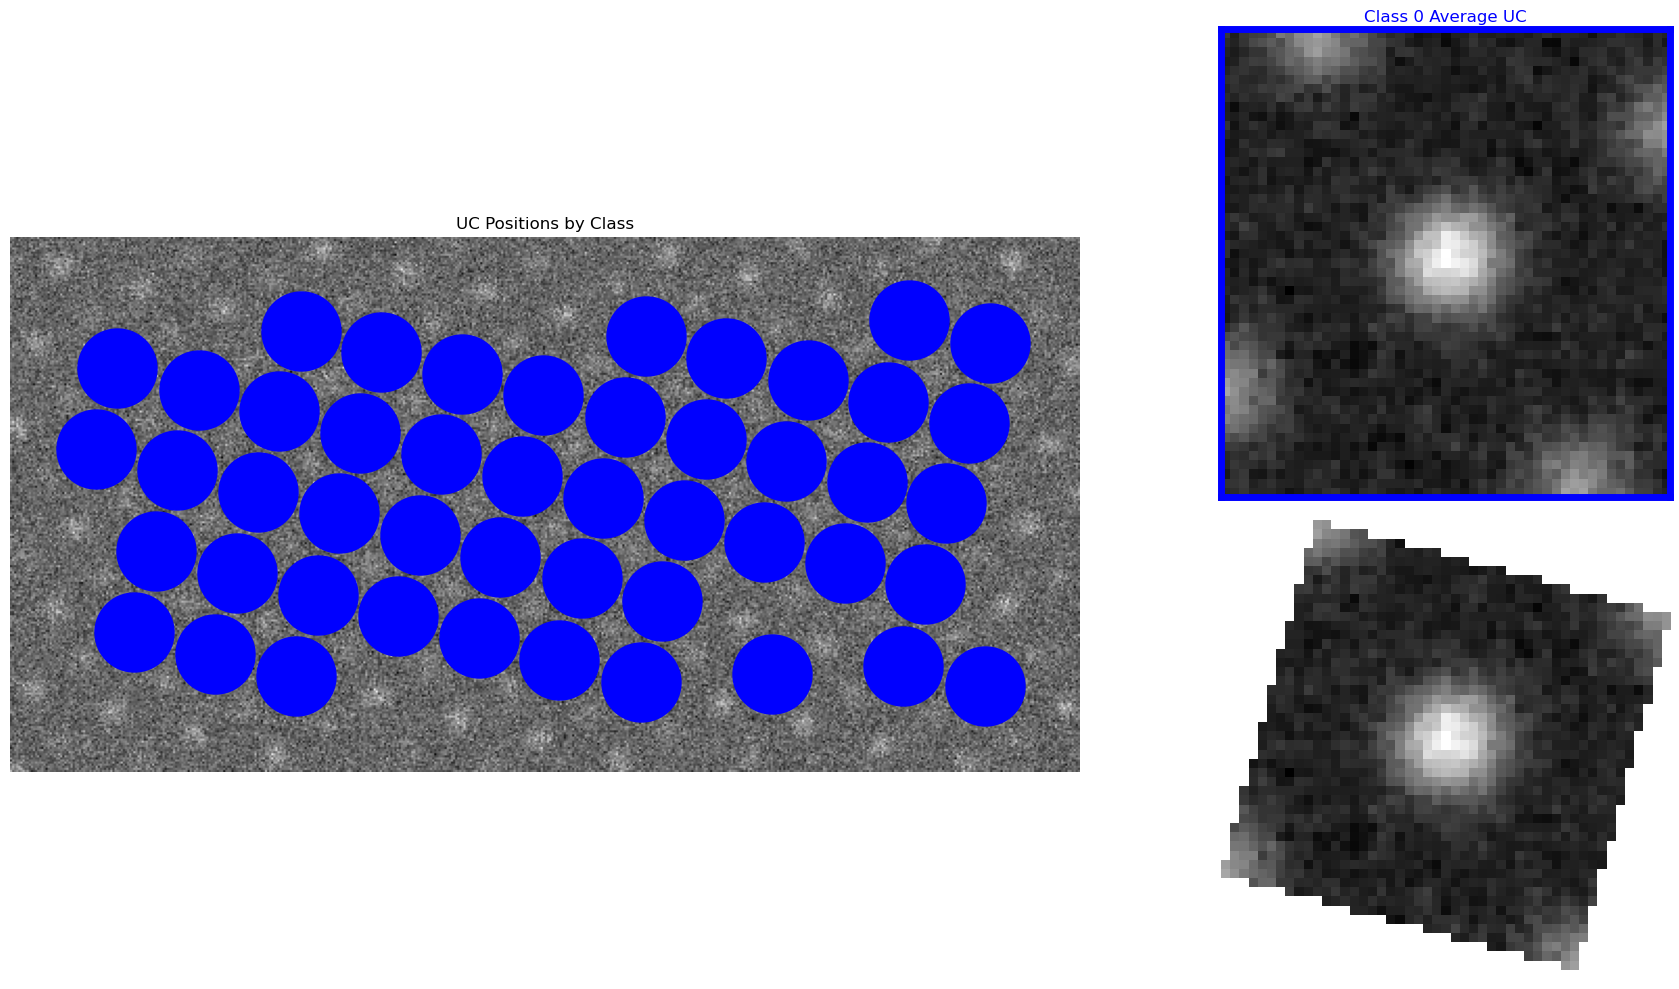

In [12]:
iM = {'r':[90]}                     #   :   symmetry to check
#Mwt = [.25,1,1]                     #   :   corresponding weights (for normalized, summed image)
alphaGuess=90
abUCoffset=[.5,.5]
verbose=1

ucAvg, UCmask, pks, UCSymmAvg, UCSymmMask, outDict = ucFromSymm(im, iM, abUCoffset=abUCoffset, alphaGuess=alphaGuess, verbose=2)

131072
Initial scale estimate by FFT: 17.50


c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (25) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (24) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


22201


Fitting swImDIff Peaks...:  40%|████      | 17/42 [00:00<00:00, 162.98it/s]c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools\PeakFinding\peakfitting.py:41: RuntimeWarning: invalid value encountered in double_scalars
  elipt = ((coeff[3]*(np.sin(theta)**2)-coeff[4]*np.sin(theta)*np.cos(theta) + coeff[5]*(np.cos(theta)**2))/(coeff[3]*(np.cos(theta)**2)+coeff[4]*(np.cos(theta)*np.sin(theta))+coeff[5]*(np.sin(theta)**2)))**.5
Fitting swImDIff Peaks...: 100%|██████████| 42/42 [00:00<00:00, 296.21it/s]


Downsampled by [2x2]
0 Adding Rotation Symmetry 90.00 degrees
Checking Rotation (90.00 deg)...
Completed
32768


Creating Unit Cell Stack...: 100%|██████████| 97/97 [00:00<00:00, 1081.70it/s]
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Autoselected 2 classes


Creating Unit Cell Stack...: 100%|██████████| 97/97 [00:00<00:00, 1258.00it/s]
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools\Networks\findDefinedNbrs.py:53: RuntimeWarning: invalid value encountered in remainder
  if ((not np.isfinite(missingVal)) | (np.mod(missingVal,1)!=0)):


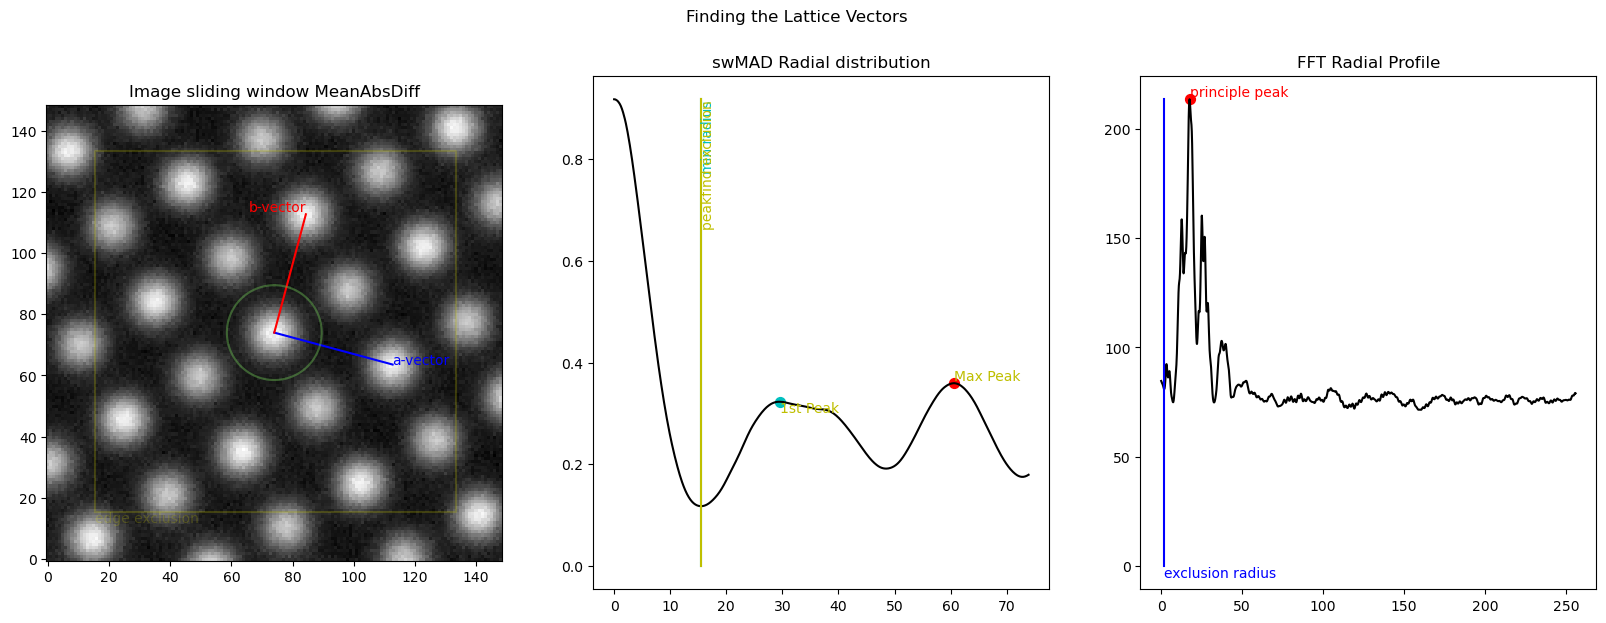

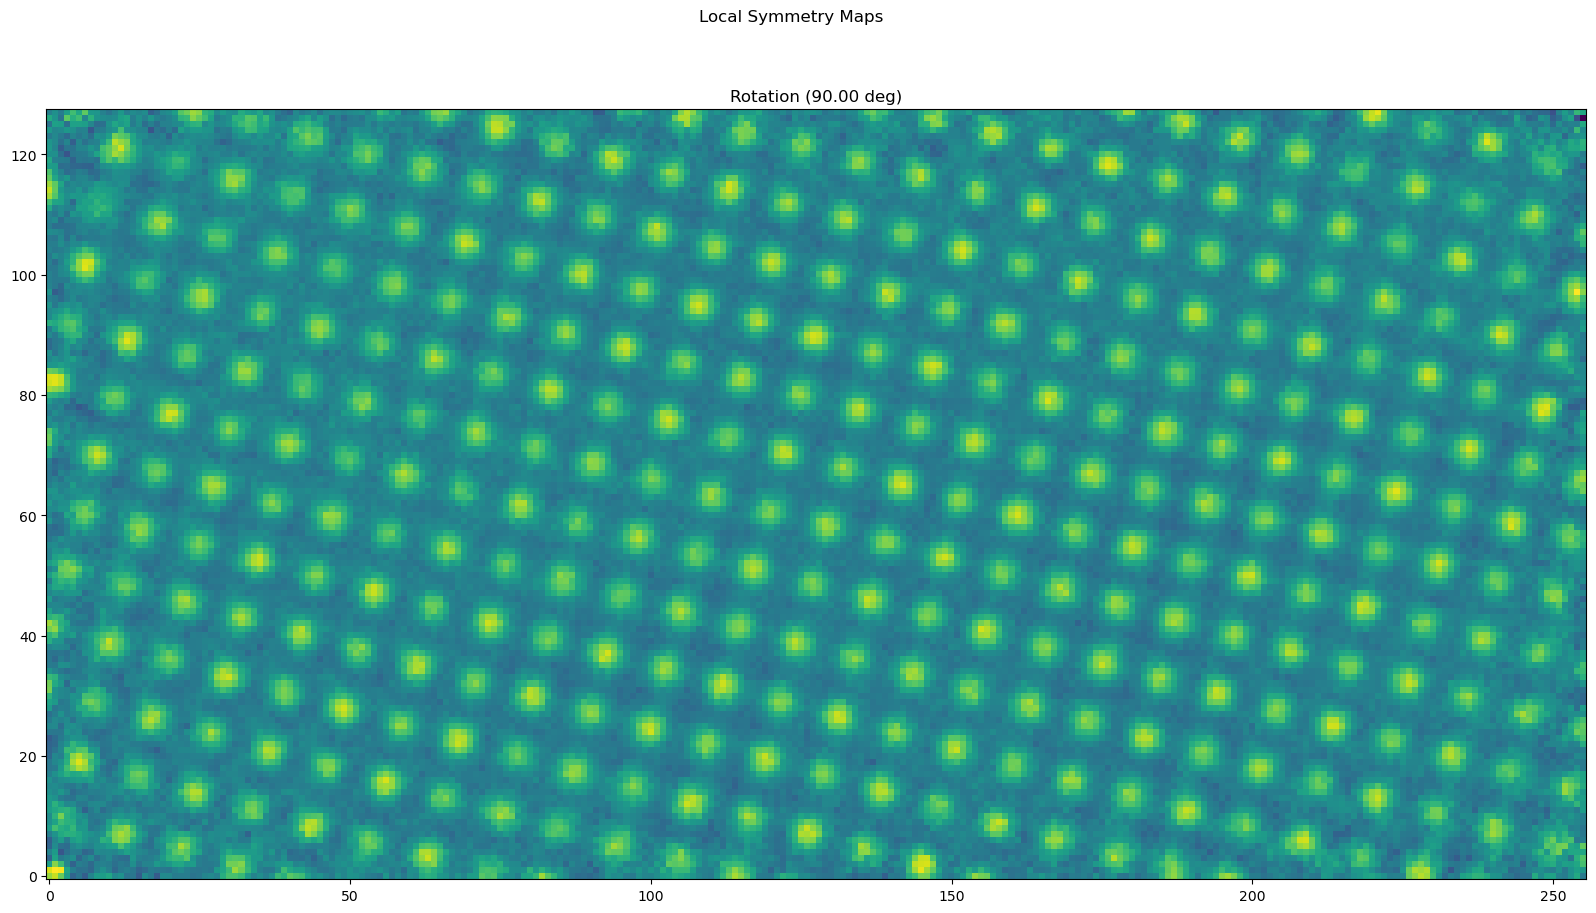

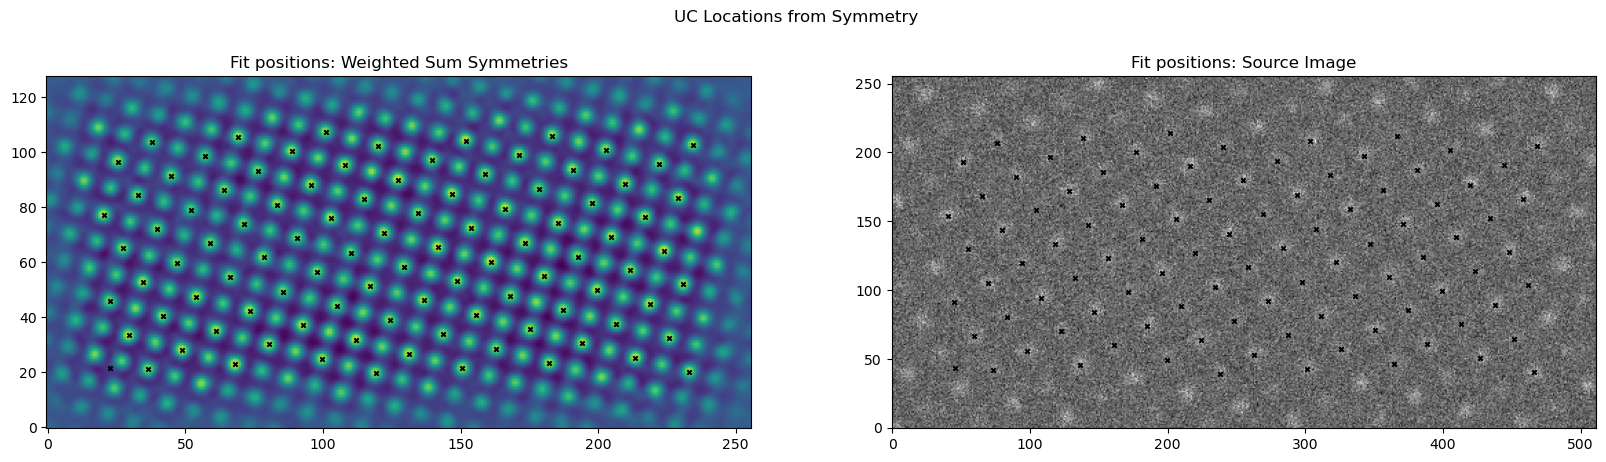

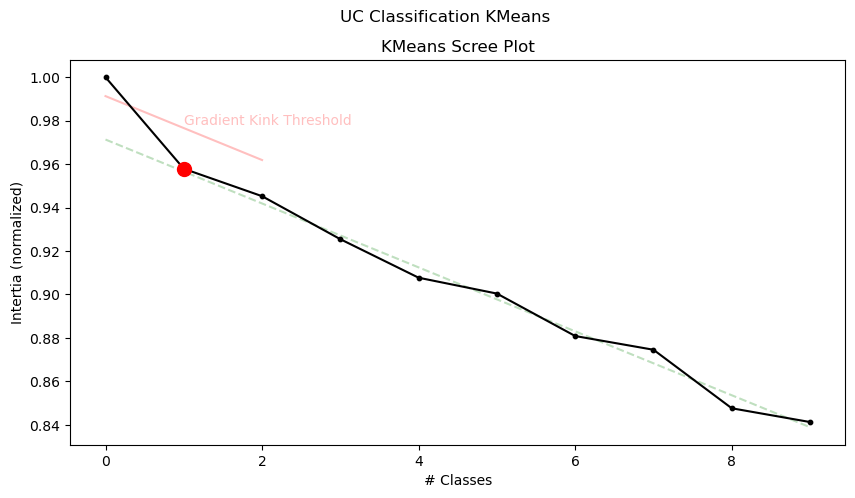

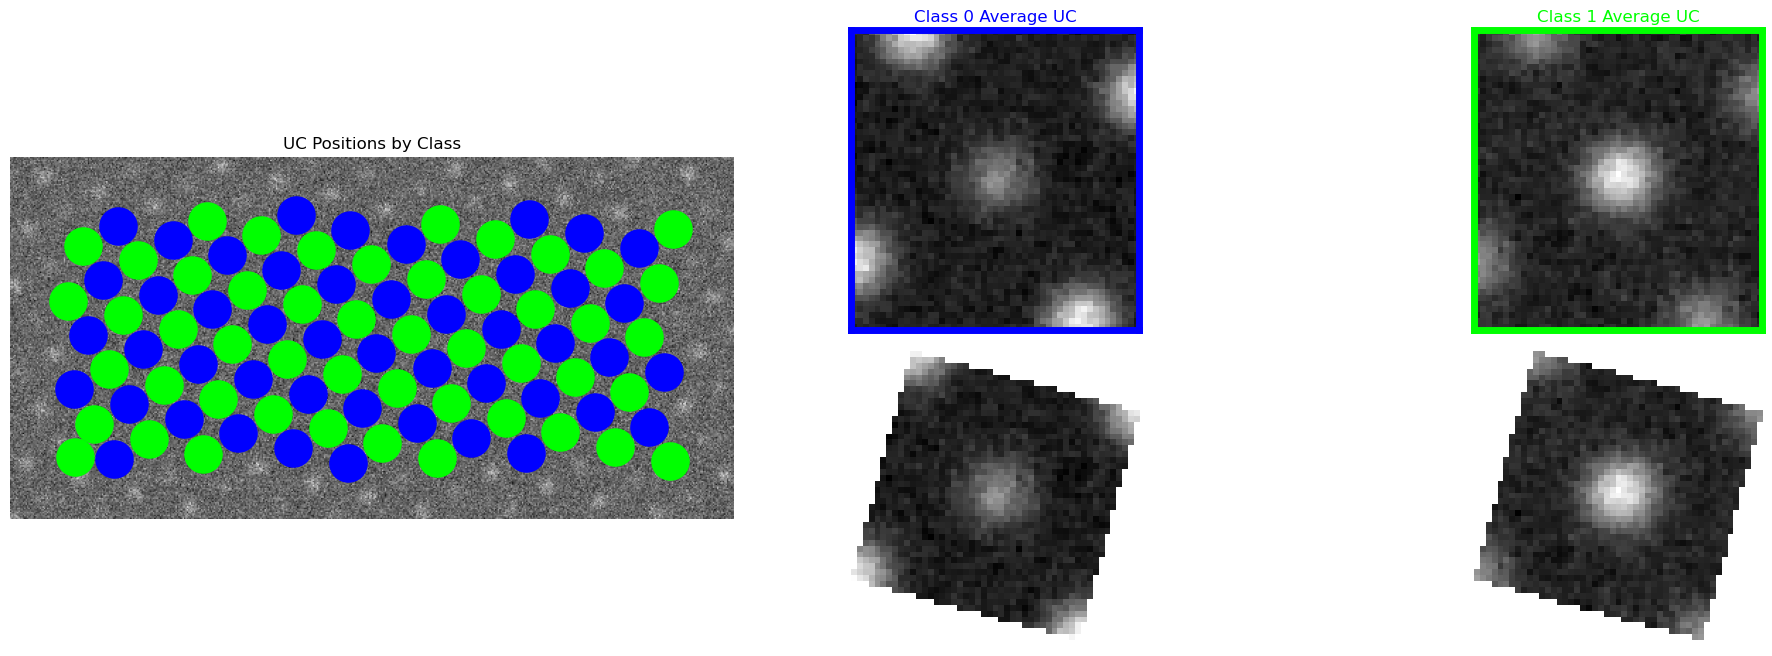

In [13]:
iM = {'r':[90]}                     #   :   symmetry to check
#Mwt = [.25,1,1]                     #   :   corresponding weights (for normalized, summed image)
alphaGuess=90
abUCoffset=[.5,.5]
verbose=1

ucAvg, UCmask, pks, UCSymmAvg, UCSymmMask, outDict = ucFromSymm(im, iM, abUCoffset=abUCoffset, rExclScalar=.6, alphaGuess=alphaGuess, verbose=2)